In [1]:
import torch
import torch.autograd
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import time
from matplotlib import animation, rc
from IPython.display import HTML
import ot
import ot.plot

## Optimize using sliced Wasserstein distance

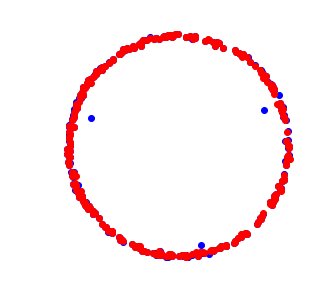

In [12]:
def generateTheta(L,endim):
    # This function generates L random samples from the unit `ndim'-u
    theta=[w/np.sqrt((w**2).sum()) for w in np.random.normal(size=(L,endim))]
    return np.asarray(theta).T
N = 300
d = 2
f = np.random.rand(N, 2) - .5;
theta = 2 * np.pi * np.random.rand(1, N)
r = .99 + .01 * np.random.randn(1, N)
g = np.vstack([np.cos(theta) * r, np.sin(theta) * r]).T

f1 = torch.from_numpy(f.copy())
f1.requires_grad = True
g1 = torch.from_numpy(g)

ims = []
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('equal')
ax.set_axis_off()
optimizer = optim.Adam([f1], lr=5e-2)
while True:
    ims.append(ax.plot(f1.data.numpy()[:, 0], f1.data.numpy()[:, 1], 'bo',
                  g[:, 0], g[:, 1], 'ro'))
    L=10 # Number of random projections
    theta = torch.from_numpy(generateTheta(L, d))
    projg = torch.mm(g1, theta)
    projg_sorted = torch.topk(projg, k=N, dim=0)[0]
    optimizer.zero_grad()
    projf = torch.mm(f1, theta)
    W2 = (torch.topk(projf, k=N, dim=0)[0] - projg_sorted)**2
    W2 = torch.mean(W2)
    W2.backward()
    optimizer.step()
    if W2.item() < 1e-5:
        break

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani.to_jshtml())

## Optimize using true Wasserstein distance

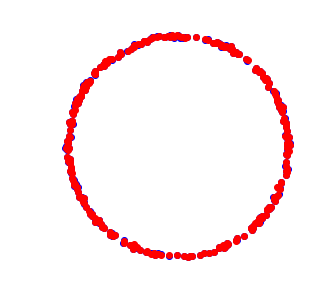

In [13]:
N = 300
d = 2
a, b = np.ones((N,)) / N, np.ones((N,)) / N  # points have equal probability of 1/N
f = np.random.rand(N, 2) - .5;
theta = 2 * np.pi * np.random.rand(1, N)
r = .99 + .01 * np.random.randn(1, N)
g = np.vstack([np.cos(theta) * r, np.sin(theta) * r]).T

f1 = torch.from_numpy(f.copy())
f1.requires_grad = True
g1 = torch.from_numpy(g)

ims = []
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('equal')
ax.set_axis_off()
optimizer = optim.Adam([f1], lr=5e-2)
while True:
    ims.append(ax.plot(f1.data.numpy()[:, 0], f1.data.numpy()[:, 1], 'bo',
                  g[:, 0], g[:, 1], 'ro'))
    optimizer.zero_grad()
    M = ot.dist(f1.data.numpy(), g, metric='sqeuclidean')
    G = ot.emd(a, b, M)
    ix1, ix2 = np.nonzero(G)
#     W2 = torch.mean(torch.norm(f1 - torch.from_numpy(g[ix2]), p=2, dim=1))
    W2 = torch.mean(torch.sum((f1 - torch.from_numpy(g[ix2]))**2, dim=1))
    W2.backward()
    optimizer.step()
    if W2.item() < 1e-5:
        break

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani.to_jshtml())